## Bare pretrained Resnet backbone evaluation

In [1]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import cohen_kappa_score, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import os
from torchsummary import summary
import numpy as np

BATCH = 32
label_names = ["D", "G", "A"]
device = "cuda" if torch.cuda.is_available() else "cpu"
resnet_dir = "../pretrained_backbone/ckpt_resnet18_ep50.pt"

c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_images= "../images/train"
train_labels = "../train.csv"
val_images = "../images/val"
val_labels = "../val.csv"
offsite_test_images = "../images/offsite_test"
offsite_test_labels = "../offsite_test.csv"
onsite_test_images = "../images/onsite_test"
onsite_test_labels = "../onsite_test_submission.csv"

## Datasets

In [3]:
class RetinaMultiLabelDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row.iloc[0])
        img = Image.open(img_path).convert("RGB")
        labels = torch.tensor(row[1:].values.astype("float32"))
        if self.transform:
            img = self.transform(img)
        return img, labels

### Image transform

In [4]:
img_size=256
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

In [5]:
BATCH = 32

train = RetinaMultiLabelDataset(train_labels, train_images, transform = transform)
val = RetinaMultiLabelDataset(val_labels, val_images, transform = transform)

offsite_test = RetinaMultiLabelDataset(offsite_test_labels, offsite_test_images, transform = transform)
onsite_test = RetinaMultiLabelDataset(onsite_test_labels, onsite_test_images, transform = transform)


### Model

In [6]:
class Classifier(nn.Module):
    def __init__(self, backbone = "resnet", dir = None):
        super().__init__()

        if dir == None:
            raise FileNotFoundError
        layers = torch.load(dir)

        if backbone == "resnet":
            self.model = models.resnet18()
            self.model.fc = nn.Linear(self.model.fc.in_features, 3)
        elif backbone == "efficientnet":
            self.model = models.efficientnet_b0()
            self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 3)
        else:
            raise ValueError("Unsupported backbone")
        self.model.load_state_dict(layers)
    
    def forward(self, X):
        return self.model(X)
        
model = Classifier(backbone="resnet", dir = resnet_dir).to(device)
summary(model, (3, 256, 256), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

## No fine-tuning: Evaluation directly on ODIR test set

In [7]:
def eval_model(model, dataset, csv_file = None, report = False):

    loader = DataLoader(dataset, BATCH, shuffle=False)
    preds = []
    model.eval()
    with torch.no_grad():
        for X, _ in tqdm(loader):
            output = (nn.functional.sigmoid(model(X.to(device))) > 0.5).long()
            preds.extend(output.cpu().numpy())

    preds = np.stack(preds)
    if report:
        cr = classification_report(dataset.data[label_names].to_numpy(), preds, target_names=label_names, zero_division= np.nan)
        print(cr)
    if csv_file:
        data = dataset.data.copy()
        data[label_names] = preds
        data.to_csv(csv_file, index = False)

### Onsite

In [8]:
eval_model(model, offsite_test, report= True)

100%|██████████| 7/7 [00:00<00:00,  7.79it/s]

              precision    recall  f1-score   support

           D       0.75      0.36      0.48       140
           G       0.52      0.55      0.53        49
           A       0.36      0.77      0.49        22

   micro avg       0.57      0.45      0.50       211
   macro avg       0.54      0.56      0.50       211
weighted avg       0.65      0.45      0.50       211
 samples avg       0.59      0.43      0.38       211



### Offsite

![](resnet_no_tuning.png)

In [9]:
eval_model(model, onsite_test, "resnet_submission_notune.csv")

100%|██████████| 8/8 [00:00<00:00,  8.13it/s]


## Frozen backbone, fine-tuning classifier only

In [10]:
params = model.parameters()
for layer in params:
        layer.requires_grad = False
for param in model.model.fc.parameters():
        param.requires_grad = True
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [11]:
checkpoints_dir = "../trained_models/"


def train_model(model, train_data, eval_data, optimizer, criterion, epochs, stepLR = None, checkpoint_name = None):
    train_loader = DataLoader(train_data,  BATCH, shuffle=True)
    val_loader = DataLoader(eval_data, BATCH, shuffle=False)
    train_size = len(train_data.data)
    eval_size = len(eval_data.data)

    train_losses = []
    val_losses = []

    f1 = []
    accuracy = []
    best_score = np.inf
    for i in range(epochs):
        model.train()
        train_loss = 0
        val_loss = 0
        val_f1 = 0
        val_accuracy = 0

        for (X, Y) in tqdm(train_loader, desc = "Training"):
            if device == "cuda":
                X = X.to(device)
                Y = Y.to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, Y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X.size(0)
            
        train_loss = train_loss / train_size

        model.eval()
        preds = []
        with torch.no_grad():
            for (X, Y) in tqdm(val_loader, desc="Validation"):
                if device == "cuda":
                    X = X.to(device)
                    Y = Y.to(device)
                output = model(X)
                loss = criterion(output, Y)
                val_loss += loss.item() * X.size(0)
                output = nn.functional.sigmoid(output)
                preds.extend((output > 0.5).cpu().long().numpy())
        
        preds = np.stack(preds)

        val_loss = val_loss / eval_size
        val_accuracy = accuracy_score(eval_data.data[label_names].to_numpy(), preds)
        val_f1 = f1_score(eval_data.data[label_names].to_numpy(), preds, average="macro")

        print(f"Epoch: {i} - Train Loss: {train_loss:2f} - Val Loss: {val_loss:2f} - Val Accuracy: {val_accuracy:2f} - Val F1 (macro): {val_f1:2f}")
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        #saving model if score imporved
        if best_score > val_loss :
            print("Model improved! Saving if checkpoint_name is set.")
            best_score = val_loss
            if checkpoint_name != None:
                torch.save(model.state_dict(), checkpoints_dir + checkpoint_name)
        f1.append(val_f1)
        accuracy.append(val_accuracy)
        if stepLR != None:
                stepLR.step()
    
    x = range(0, epochs)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(x, train_losses, label = "Train Loss")
    plt.plot(x, val_losses, label = "Val Loss")
    plt.legend()
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.title("BCE Loss")
    plt.subplot(1, 3, 2)
    plt.plot(x, f1)
    plt.title("Val F1 (macro)")
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.subplot(1, 3, 3)
    plt.plot(x, accuracy)
    plt.title("Val accuracy")
    plt.ylabel("Metric")
    plt.xlabel("Epoch")
    plt.show()

    return train_losses, val_losses, f1, accuracy

Using Adam with default parameters, no weight decay + a bit of LR scheduling

Validation: 100%|██████████| 7/7 [00:00<00:00,  8.88it/s]


Epoch: 0 - Train Loss: 1.190938 - Val Loss: 0.808287 - Val Accuracy: 0.360000 - Val F1 (macro): 0.519700
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.02it/s]


Epoch: 1 - Train Loss: 0.612966 - Val Loss: 0.570450 - Val Accuracy: 0.525000 - Val F1 (macro): 0.528374
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch: 2 - Train Loss: 0.494840 - Val Loss: 0.546880 - Val Accuracy: 0.560000 - Val F1 (macro): 0.478641
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.79it/s]


Epoch: 3 - Train Loss: 0.479611 - Val Loss: 0.523918 - Val Accuracy: 0.570000 - Val F1 (macro): 0.498072
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.68it/s]


Epoch: 4 - Train Loss: 0.468699 - Val Loss: 0.506533 - Val Accuracy: 0.565000 - Val F1 (macro): 0.495006
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.26it/s]


Epoch: 5 - Train Loss: 0.459771 - Val Loss: 0.543589 - Val Accuracy: 0.555000 - Val F1 (macro): 0.415692


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.23it/s]


Epoch: 6 - Train Loss: 0.457771 - Val Loss: 0.531102 - Val Accuracy: 0.575000 - Val F1 (macro): 0.467571


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.47it/s]


Epoch: 7 - Train Loss: 0.461663 - Val Loss: 0.518757 - Val Accuracy: 0.560000 - Val F1 (macro): 0.454524


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.92it/s]


Epoch: 8 - Train Loss: 0.444009 - Val Loss: 0.498751 - Val Accuracy: 0.565000 - Val F1 (macro): 0.523618
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.52it/s]


Epoch: 9 - Train Loss: 0.444326 - Val Loss: 0.512810 - Val Accuracy: 0.585000 - Val F1 (macro): 0.467708


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.24it/s]


Epoch: 10 - Train Loss: 0.449739 - Val Loss: 0.483017 - Val Accuracy: 0.580000 - Val F1 (macro): 0.558238
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.40it/s]


Epoch: 11 - Train Loss: 0.441140 - Val Loss: 0.501202 - Val Accuracy: 0.570000 - Val F1 (macro): 0.493128


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.30it/s]


Epoch: 12 - Train Loss: 0.445021 - Val Loss: 0.516831 - Val Accuracy: 0.590000 - Val F1 (macro): 0.472969


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.57it/s]


Epoch: 13 - Train Loss: 0.439461 - Val Loss: 0.485889 - Val Accuracy: 0.570000 - Val F1 (macro): 0.508159


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.47it/s]


Epoch: 14 - Train Loss: 0.440156 - Val Loss: 0.472695 - Val Accuracy: 0.580000 - Val F1 (macro): 0.541803
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.43it/s]


Epoch: 15 - Train Loss: 0.444491 - Val Loss: 0.483374 - Val Accuracy: 0.580000 - Val F1 (macro): 0.539263


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.06it/s]


Epoch: 16 - Train Loss: 0.428130 - Val Loss: 0.476830 - Val Accuracy: 0.590000 - Val F1 (macro): 0.567037


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.54it/s]


Epoch: 17 - Train Loss: 0.425530 - Val Loss: 0.484940 - Val Accuracy: 0.580000 - Val F1 (macro): 0.523383


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.25it/s]


Epoch: 18 - Train Loss: 0.431232 - Val Loss: 0.465930 - Val Accuracy: 0.585000 - Val F1 (macro): 0.588542
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.49it/s]


Epoch: 19 - Train Loss: 0.428661 - Val Loss: 0.488777 - Val Accuracy: 0.590000 - Val F1 (macro): 0.521190


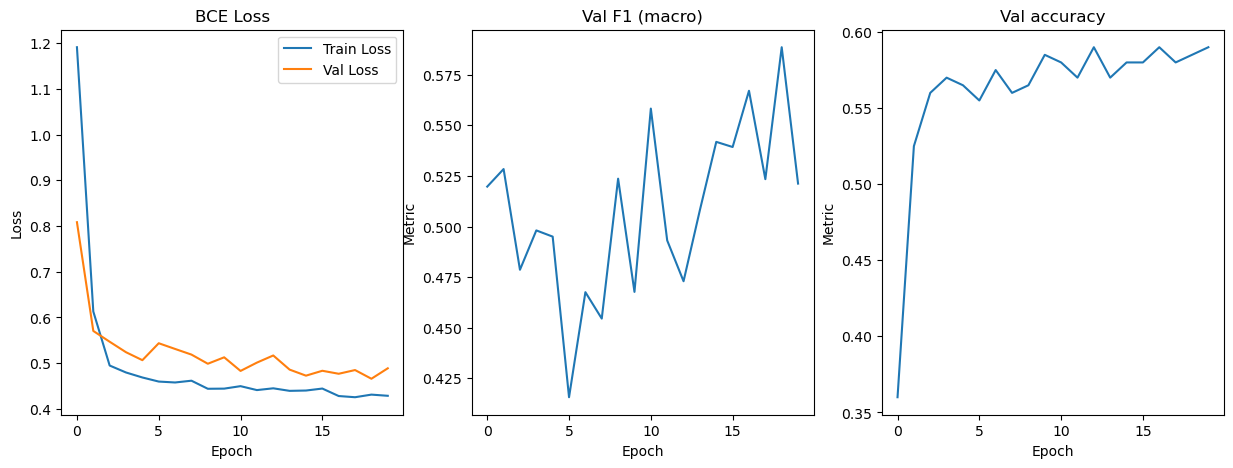

In [12]:
optimizer = torch.optim.AdamW(model.model.fc.parameters(), lr = 1e-3, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=8, gamma=0.8)
result = train_model(model, train, val, optimizer, criterion, epochs=20, stepLR=scheduler, checkpoint_name="resnet_tuned_classifer.pt")

### Offsite test

In [13]:
model = Classifier(backbone="resnet", dir = resnet_dir).to(device)
model.load_state_dict(torch.load(checkpoints_dir + "resnet_tuned_classifer.pt"))
eval_model(model, offsite_test, report= True)

100%|██████████| 7/7 [00:00<00:00,  8.05it/s]

              precision    recall  f1-score   support

           D       0.83      0.83      0.83       140
           G       0.70      0.33      0.44        49
           A       0.60      0.41      0.49        22

   micro avg       0.79      0.67      0.72       211
   macro avg       0.71      0.52      0.59       211
weighted avg       0.77      0.67      0.70       211
 samples avg       0.80      0.68      0.69       211



### Onsite test
![](resnet_classifier_tuning.png)

In [14]:
eval_model(model, onsite_test, "resnet_submission_classifier_tune.csv")

100%|██████████| 8/8 [00:01<00:00,  7.98it/s]


## Full fine-tuning

We previously tuned the classifer, and we further now tune everything, using the best model from previous stage

Using AdamW with default weight decay of 1e-4, 5 epochs, exponential reduction.

Validation: 100%|██████████| 7/7 [00:00<00:00,  8.16it/s]


Epoch: 0 - Train Loss: 0.386487 - Val Loss: 0.518734 - Val Accuracy: 0.615000 - Val F1 (macro): 0.630951
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.67it/s]


Epoch: 1 - Train Loss: 0.245030 - Val Loss: 0.424482 - Val Accuracy: 0.675000 - Val F1 (macro): 0.645537
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.36it/s]


Epoch: 2 - Train Loss: 0.166397 - Val Loss: 0.404536 - Val Accuracy: 0.695000 - Val F1 (macro): 0.709591
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.50it/s]


Epoch: 3 - Train Loss: 0.150371 - Val Loss: 0.404930 - Val Accuracy: 0.715000 - Val F1 (macro): 0.718728


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.44it/s]


Epoch: 4 - Train Loss: 0.140888 - Val Loss: 0.404809 - Val Accuracy: 0.710000 - Val F1 (macro): 0.718216


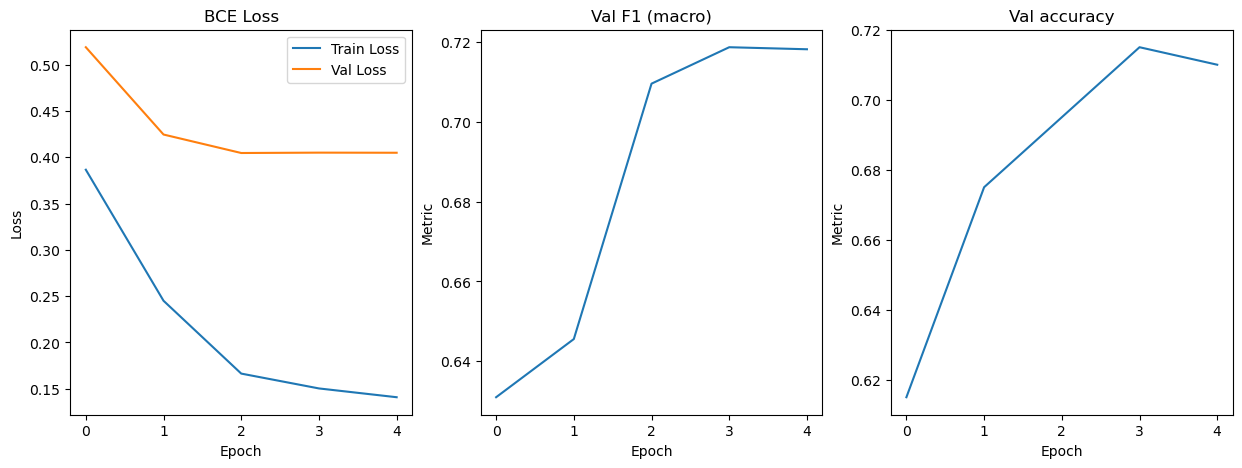

In [15]:
for layer in model.parameters():
    layer.requires_grad = True
'''
for m in model.modules():
    if isinstance(m, nn.BatchNorm2d):
        m.eval()                        
        m.track_running_stats = False    
        for p in m.parameters():
             p.requires_grad = False  
'''
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.2)
result = train_model(model, train, val, optimizer=optimizer, criterion=criterion, epochs=5, stepLR = scheduler, checkpoint_name="resnet.pt")

### Offsite

In [16]:
model = Classifier(backbone="resnet", dir = resnet_dir).to(device)
model.load_state_dict(torch.load(checkpoints_dir + "resnet.pt"))
eval_model(model, offsite_test, report= True)

100%|██████████| 7/7 [00:00<00:00,  7.38it/s]

              precision    recall  f1-score   support

           D       0.86      0.91      0.88       140
           G       0.83      0.59      0.69        49
           A       0.59      0.45      0.51        22

   micro avg       0.83      0.79      0.81       211
   macro avg       0.76      0.65      0.70       211
weighted avg       0.82      0.79      0.80       211
 samples avg       0.84      0.80      0.81       211



### Onsite test
![](resnet_classifier_full.png)

In [17]:
eval_model(model, onsite_test, "resnet_submission_full.csv")

100%|██████████| 8/8 [00:00<00:00,  8.46it/s]
